## **Twitter - Sentiment Analysis**

**Dataset:** [Sentiment140 dataset with 1.6 million tweets](https://www.kaggle.com/datasets/kazanova/sentiment140)


### Import Libraries

In [2]:
#Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import pickle

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#Download the stopwords
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vipv3\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vipv3\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load and Preprocess the Dataset

In [3]:
#Load and Preprocess the Dataset

#Load the sentiment140 csv
cols = ['target', 'ids', 'date', 'flag', 'user', 'text']

#Create df and using latin-1 for encoding
df = pd.read_csv('../Data/training.1600000.processed.noemoticon.csv', encoding='latin-1', names=cols)

df.head()


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
#We only need 2 columns for the analysis whcih is target and the text
df = df[['target', 'text']].copy()

#The polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
#Replacing 4 with 1 for positive for easily understanding
df['target'] = df['target'].replace({4: 1})

#Printing  first 5 rows 
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [7]:
#Cleaning the text - removing stopword, punctuations, and numbers and lemmatizing the data

#Create the function to clean 
def clean_dataset(text):
    text = re.sub(r'http\S+', '', text)        # remove URLs
    text = re.sub(r'@\w+', '', text)           # remove mentions
    text = re.sub(r'#\w+', '', text)           # remove hashtags
    text = re.sub(r'[^\w\s]', '', text)        # remove punctuation
    text = text.lower()                        # convert to lowercase
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word.isalpha()]
    return ' '.join(tokens) 

df['clean_text'] = df['text'].apply(clean_dataset)

#Printing  first 5 rows 
df.head()

,target,text,clean_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww thats bummer shoulda got david carr third...
1,0,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...
2,0,@Kenichan I dived many times for the ball. Man...,dived many time ball managed save rest go bound
3,0,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",behaving im mad cant see


### Exploratory Data Analysis

In [8]:
print(df['target'].value_counts())

target
0    800000
1    800000
Name: count, dtype: int64


In [9]:
print(df['target'].value_counts(normalize=True) * 100)

target
0    50.0
1    50.0
Name: proportion, dtype: float64


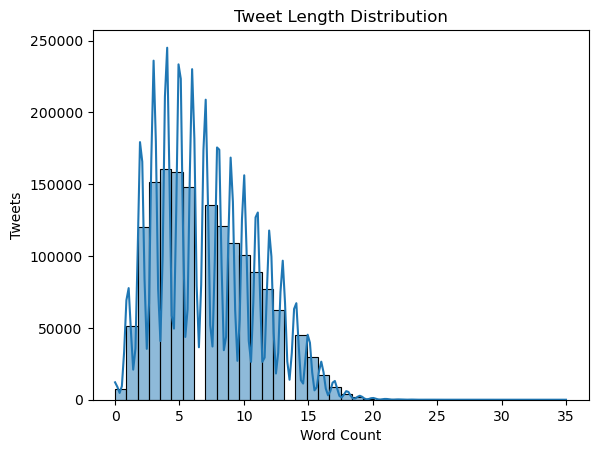

In [10]:
# Tweet length histogram
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))
sns.histplot(df['text_length'], bins=40, kde=True)
plt.title("Tweet Length Distribution")
plt.xlabel("Word Count")
plt.ylabel("Tweets")
plt.show()

### TF-IDF Vectorization

In [11]:
#Split the train - test data
X=df['clean_text']
y=df['target']

vectorizer=TfidfVectorizer(max_features=10000)
X=vectorizer.fit_transform(X)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

### Train Logistic Regression model

In [12]:
model = LogisticRegression(max_iter=10000) #using 10000 iterations to train
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

### Prediction Testing

In [13]:
pred = model.predict(X_test)

print("Classification Report: \n")
print(classification_report(y_test, pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.79      0.76      0.77    159494
           1       0.77      0.80      0.78    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



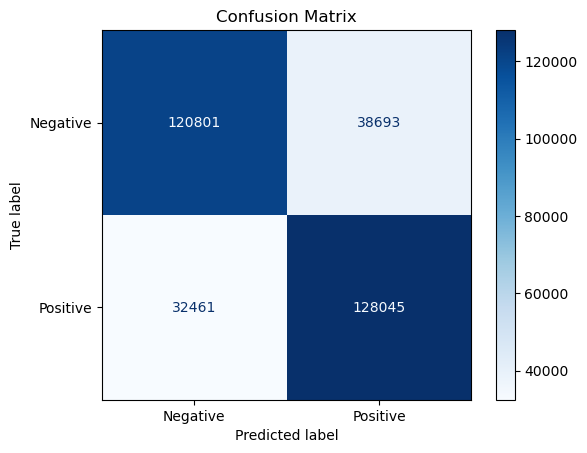

In [14]:
# Confusion Matrix
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### Save the  model using pickle 

In [15]:
with open("../Models/model.pkl", "wb") as f:
    pickle.dump(model, f)

### Save the vectorizer 

In [16]:
with open("../Models/vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)